# STATE TWITTER TROLL DETECTION USING TRANSFORMERS

### 1. DATA FOLDER

* 5 CSV files for notebooks in this series. Note that raw troll tweet files from Twitter are not included here.

### 2. NOTEBOOKS FOLDER

* Notebooks 1.0 - 1.2: Data collection, cleaning and preparation. Optional if you just want to experiment with the final dataset.

* Notebooks 2.0 - 2.1: Fine tuning distilbert with custom dataset and detailed testing with unseen validation dataset, as well as a fresh dataset with state troll tweets from Iran.

* Notebook 3.0 - 3.1: Create and test optimised logistic regression and XGB models against datasets used to assess fine tuned Distilbert model.


### 3. APP FOLDER

* app.py + folders for "static" and "template: simple app for use on a local machine to demonstrate how a state troll tweet detector can be used in deployment. Unfortunately free hosting accounts can't accomodate the disk size required for pytorch and the fine tuned model, so I've not deployed this online. 


### 4. TROLL_DETECT FOLDER

* Fine tuned Distilbert model from Colab notebook2.0. Too big for Github, download [here](https://www.dropbox.com/sh/90h7ymog2oi5yn7/AACTuxmMTcso6aMxSmSiD8AVa) from Dropbox instead.

### 5. PKL FOLDER

* Pickled logistic regression model from notebook3.0 

* Pickled XGB model from notebook3.1 

# PART 3A: COMPARE WITH LOGISTIC REGRESSION MODEL

For the sake of a more thorough comparison, let's build an optimised logistic regression model with the exact same training data and see how it performs on the same tests that the fine tuned Distilbert model was put through. Through my previous trials, I've found the log-reg model to be really good at this particular task. See notebook3.1 for a similar trial using an XGB classifier.

I assume you are familiar with the traditional BOW approach here, and won't go into details. I used this approach extensively in my [earlier project](https://github.com/chuachinhon/twitter_state_trolls_cch) on state trolls on Twitter.

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import joblib

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

mpl.rcParams["figure.dpi"] = 300
%matplotlib inline
%config InlineBackend.figure_format ='retina'

In [3]:
raw = pd.read_csv("../data/train_raw.csv")

val = pd.read_csv("../data/validate.csv").dropna(subset=["clean_text"])


In [4]:
X = raw["clean_text"]
y = raw["troll_or_not"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.2, shuffle=True, stratify=y
)


In [5]:
print(X_train.shape)
print(X_test.shape)

(71958,)
(17990,)


In [6]:
print(y_train.shape)
print(y_test.shape)

(71958,)
(17990,)


# 1. DUMMY BASELINE

The model will have to better than 0.5, which is what you get with a random guess.

In [7]:
dummy = DummyClassifier(strategy='stratified', random_state=42)

In [8]:
dummy.fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)
print("Accuracy Score:", accuracy_score(y_test, dummy_pred))

Accuracy Score: 0.5013896609227348


# 2. GRID SEARCH FOR OPTIMAL PARAMETERS

Switch up the parameters range if you have more powerful machines at your disposal. This ran for about 27 minutes, which is fairly reasonable for a trial. 

In [9]:
model = Pipeline(
    [
        ("vect", CountVectorizer(stop_words="english", ngram_range=(1, 1))),
        ("tfidf", TfidfTransformer(use_idf=True, norm="l2")),
        (
            "clf",
            LogisticRegression(
                class_weight="balanced", penalty="l2", max_iter=1000, n_jobs=-1
            ),
        ),
    ]
)

parameters = {
    "vect__min_df": [i / 1000 for i in range(1, 5)],
    "clf__random_state": (16, 32, 64),
    "clf__C": np.logspace(1, 3, 15),
    "clf__solver": ["lbfgs", "liblinear", "saga", "newton-cg"],
}

In [10]:
%%time
gs_lr = GridSearchCV(
    model,
    parameters,
    cv=5,
    n_jobs=-1,
    scoring="accuracy",
    return_train_score=True,
    verbose=1,
)

gs_lr.fit(X_train, y_train)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed: 26.7min finished


CPU times: user 1min 55s, sys: 39.9 s, total: 2min 35s
Wall time: 26min 42s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(stop_words='english')),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'clf__C': array([  10.        ,   13.89495494,   19.30697729,   26.82695795,
         37.2759372 ,   51.79474679,   71.9685673 ,  100.        ,
        138.94954944,  193.06977289,  268.26957953,  372.75937203,
        517.94746792,  719.685673  , 1000.        ]),
                         'clf__random_state': (16, 32, 64),
                         'clf__solver': ['lbfgs', 'liblinear', 'saga',
                                         'newton-cg'],
    

In [11]:
print(gs_lr.best_score_)
print(gs_lr.best_params_)

0.8128351635991382
{'clf__C': 10.0, 'clf__random_state': 16, 'clf__solver': 'lbfgs', 'vect__min_df': 0.001}


## 2.1 SAVE THE OPTIMISED MODEL

Pretty good score. Let's save the model and then expose it to the full training data ahead of testing against the validation set.

In [13]:
#joblib.dump(gs_lr.best_estimator_, "../pkl/lr.pkl", compress=1)

['../pkl/lr.pkl']

In [14]:
#joblib.dump(gs_lr.cv_results_, "../pkl/lr_results.pkl", compress=1)

['../pkl/lr_results.pkl']

# 3. LOADING OPTIMISED MODEL

In [15]:
LR = joblib.load("../pkl/lr.pkl")

In [16]:
%%time

LR.fit(X, y)

CPU times: user 776 ms, sys: 10.1 ms, total: 786 ms
Wall time: 2 s


Pipeline(steps=[('vect', CountVectorizer(min_df=0.001, stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 LogisticRegression(C=10.0, class_weight='balanced',
                                    max_iter=1000, n_jobs=-1,
                                    random_state=16))])

In [17]:
# Loading up unseen validation set

X_validate = val['clean_text']
y_validate = val['troll_or_not']

In [18]:
pred_validate = LR.predict(X_validate)

## 3.1: METRICS COMPARISON

In [23]:
print("Accuracy score: ", accuracy_score(y_validate, pred_validate))

print("Precision score: ", precision_score(y_validate, pred_validate))

print("Recall score: ", recall_score(y_validate, pred_validate))

print("F1 score: ", f1_score(y_validate, pred_validate))

Accuracy score:  0.8223
Precision score:  0.8248911753066878
Recall score:  0.8237502469867615
F1 scoe:  0.8243203163618389


### The log-reg model performed really well, in my view, but well short of the performance by the fine tuned Distilbert model, which achieved scores of above 0.9 for accuracy, precision and recall. Let's take a closer look via a confusion matrix

## 3.2: CONFUSION MATRIX FOR LOG-REG MODEL

If you compare with the similar section in notebook2.1, you can tell at a glance that the log-reg model has twice the number of false positives and false negatives compared to the Distilbert model. So while the two models might seem "close" in terms of classification metrics - 0.9+ Versus 0.8+ - the difference in real world results is very significant.

And the number of wrongly classified tweets will go up significantly as you run the model through larger datasets.

In [19]:
cm_validate = confusion_matrix(y_validate, pred_validate)
cm_validate

array([[4054,  885],
       [ 892, 4169]])

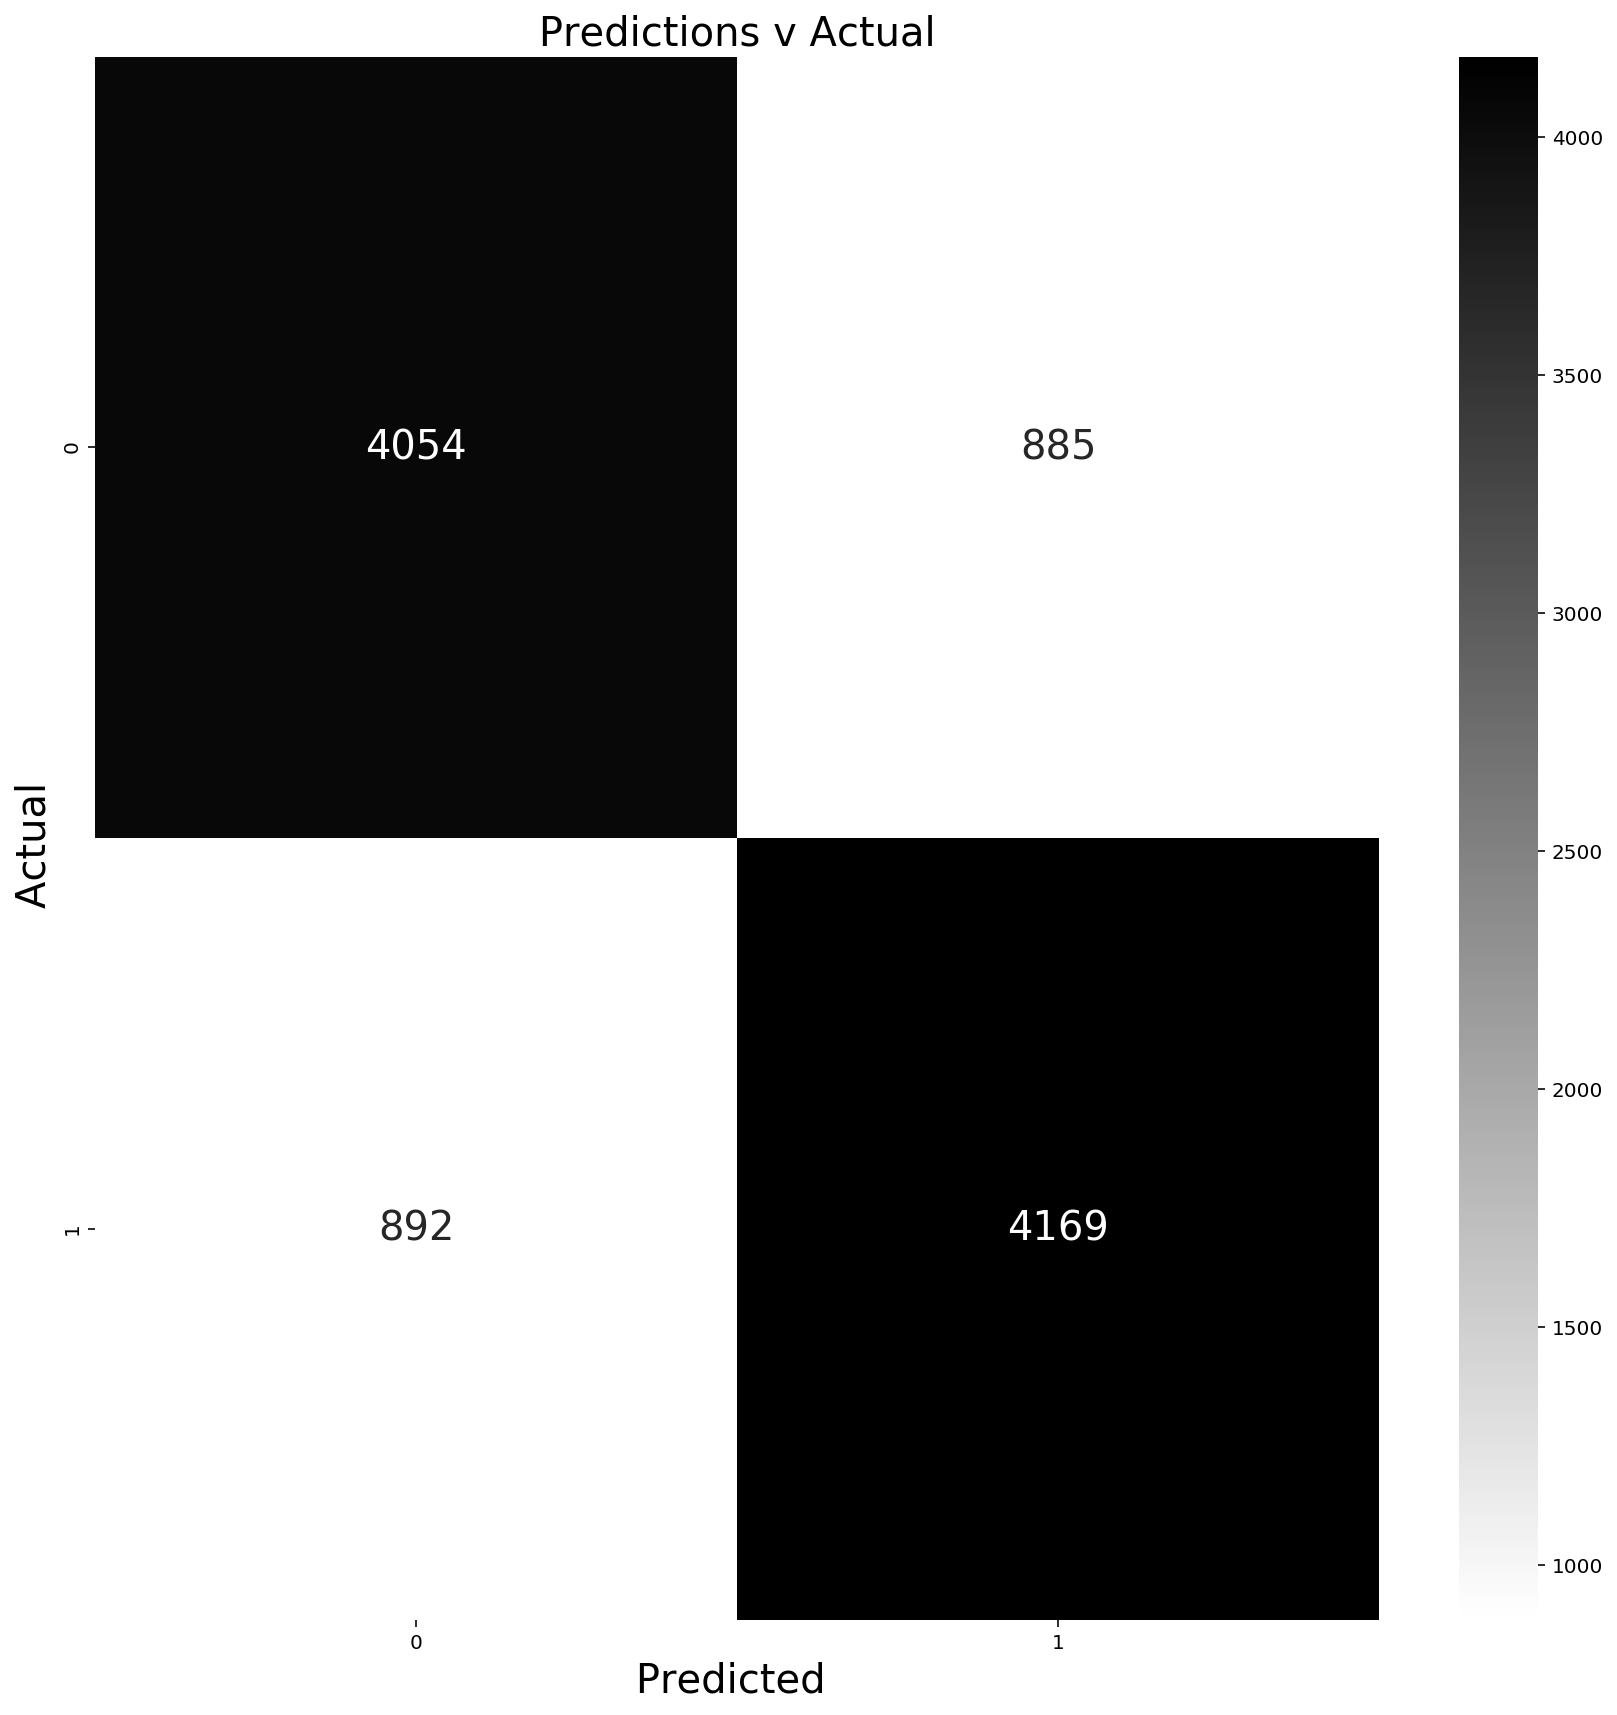

In [20]:
plt.figure(figsize=(12,12))
sns.heatmap(cm_validate, annot=True, fmt="d", cmap="gist_gray_r", annot_kws={"size": 20})
plt.title("Predictions v Actual", fontsize=20)
plt.ylabel("Actual ", fontsize=20)
plt.xlabel("Predicted ", fontsize=20)
plt.tight_layout()

# 4. TEST LOG-REG MODEL AGAINST IRAN DATASET

Like the Distilbert model, the log-reg version was trained on state troll tweets from China and Russia. How will the log-reg model perform when tasked with classifing state troll tweets from Iran?

In [24]:
# this dataset is in the repo

iran = pd.read_csv("../data/iran.csv")

In [25]:
cols1 = ["tweetid", "bot_or_not", "user_screen_name", "tweet_text", "clean_tweet_text"]

iran = iran[cols1].copy()

iran = iran.rename(
    columns={
        "tweetid": "tweetid",
        "bot_or_not": "troll_or_not",
        "user_screen_name": "user_display_name",
        "tweet_text": "tweet_text",
        "clean_tweet_text": "clean_text",
    }
)

iran = iran.dropna(subset=['clean_text']).copy()

In [26]:
# Loading up Iran set

X_iran = iran['clean_text']
y_iran = iran['troll_or_not']

In [27]:
pred_iran = LR.predict(X_iran)

## 4.1: METRICS

Accuracy, precision and recall scores all dropped noticably, just as we observed for the Distilbert model as well. But the transformer model's performance against the Iran dataset held up much better (still in the mid 0.7+ range). 

In [28]:
print("Accuracy score: ", accuracy_score(y_iran, pred_iran))

print("Precision score: ", precision_score(y_iran, pred_iran))

print("Recall score: ", recall_score(y_iran, pred_iran))

print("F1 scoe: ", f1_score(y_iran, pred_iran))

Accuracy score:  0.6021073758153538
Precision score:  0.6308470290771175
Recall score:  0.499
F1 scoe:  0.5572305974316025


## 4.2: CONFUSION MATRIX FOR IRAN DATASET 

When exposed to state troll tweets from another country, the log-reg model doesn't perform as well in correctly identifying the troll tweets, resulting in a very high number of false negatives. It only succeeded in correctly picking out about half the troll tweets (499 out of 1,000) in this dataset.

The fine tuned Distilbert model held up much better in this scenario, raising hopes that it might do as well against, say, state troll tweets from Saudi Arabia or Bangladesh. 

In [30]:
cm_iran = confusion_matrix(y_iran, pred_iran)
cm_iran

array([[701, 292],
       [501, 499]])

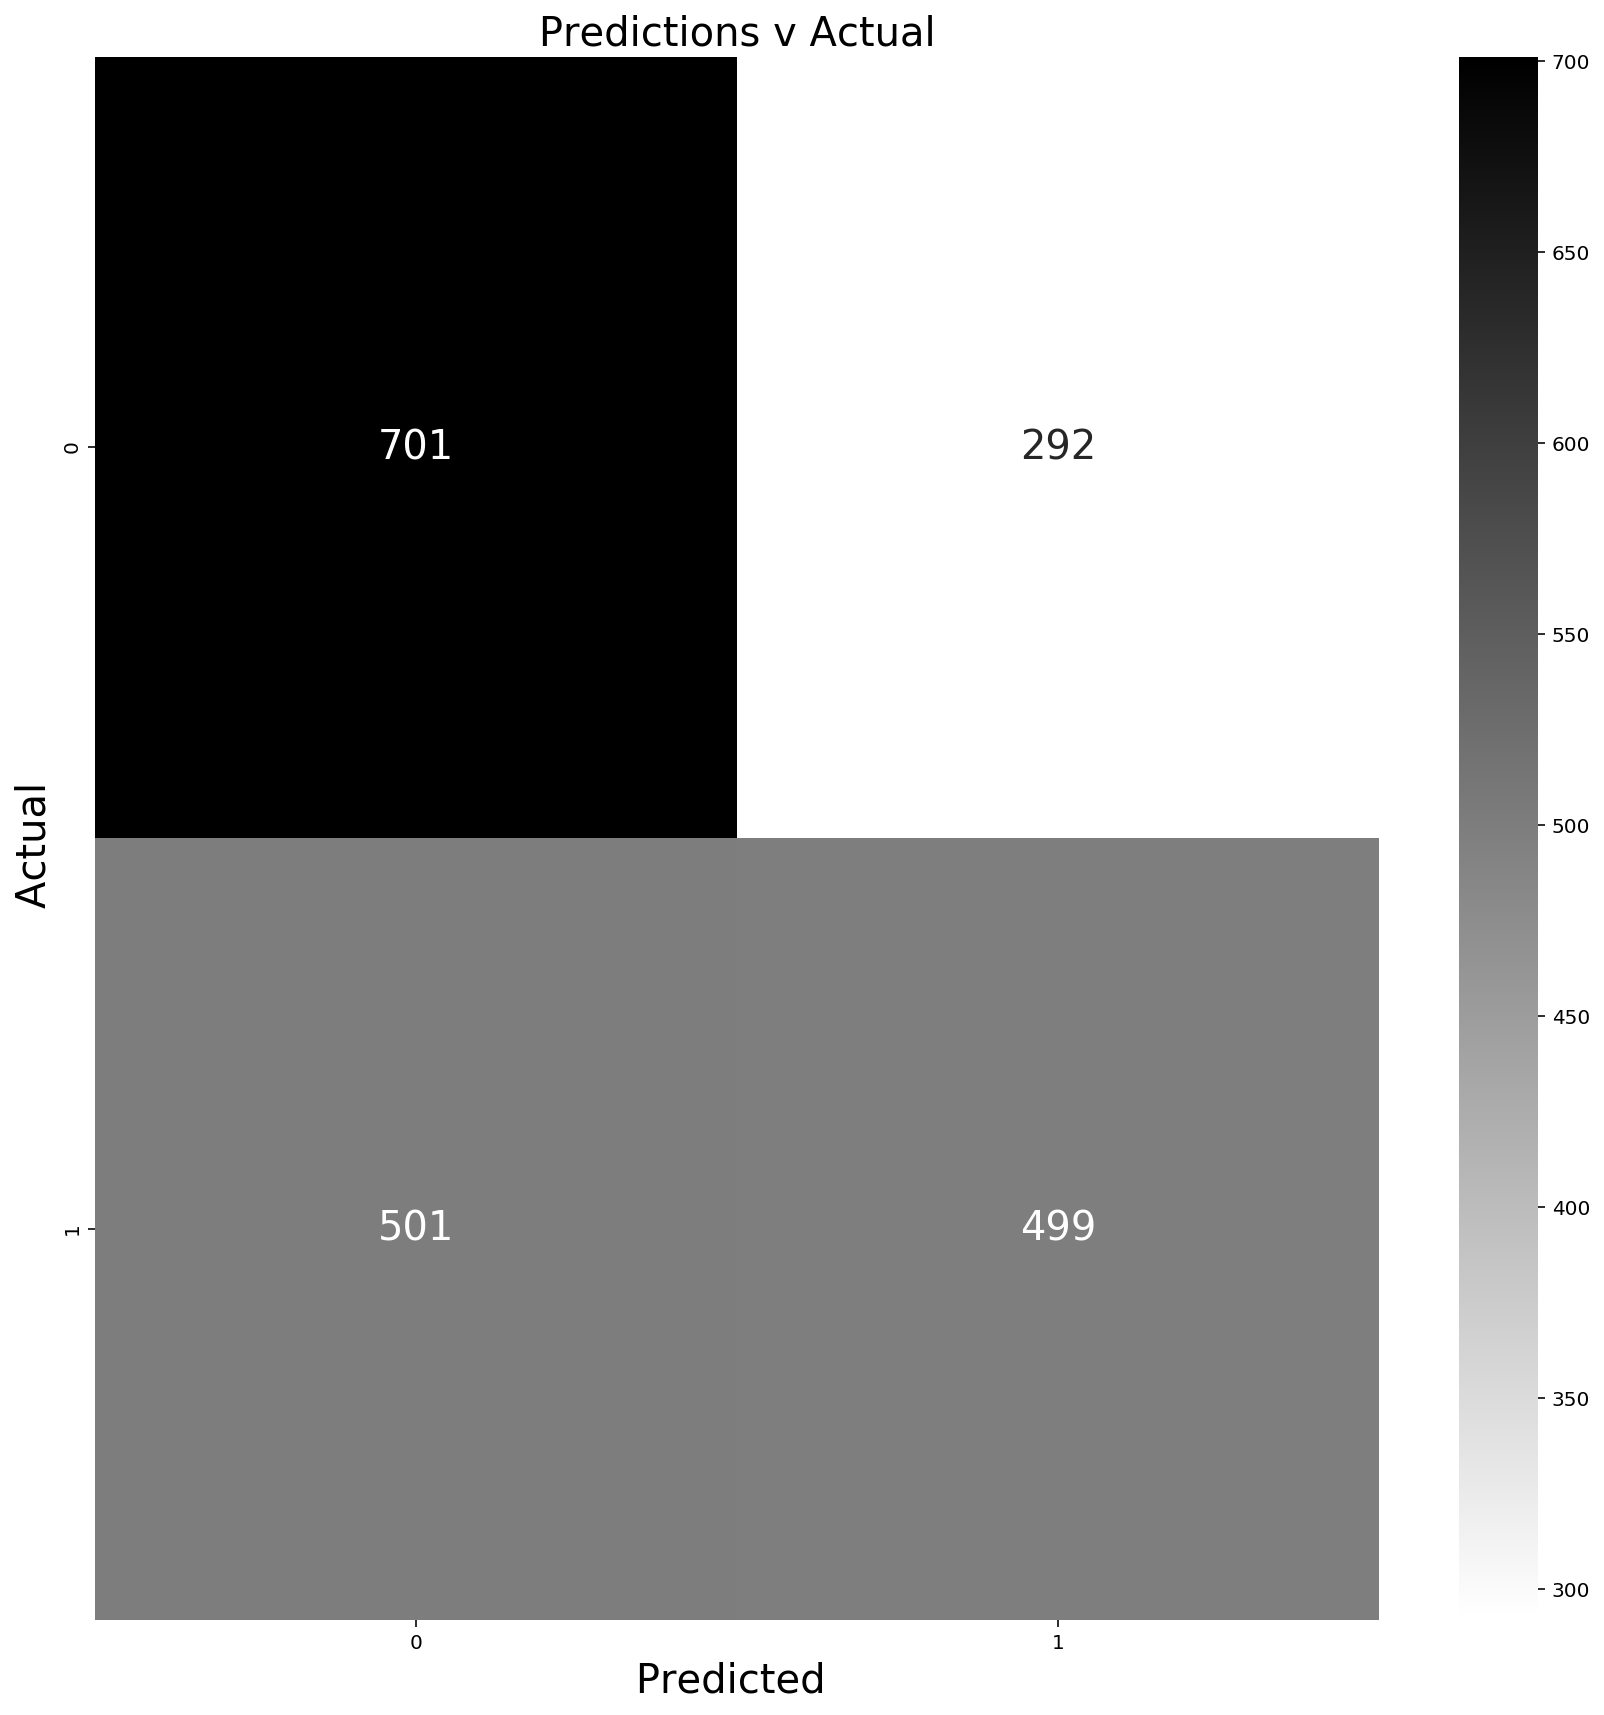

In [35]:
plt.figure(figsize=(12,12))
sns.heatmap(cm_iran, annot=True, fmt="d", cmap="gist_gray_r", annot_kws={"size": 20})
plt.title("Predictions v Actual", fontsize=20)
plt.ylabel("Actual ", fontsize=20)
plt.xlabel("Predicted ", fontsize=20)
plt.tight_layout()